In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Improving Medical Predictions by Irregular Multimodal Electronic Health Records Modeling

# Introduction
This paper pretends to address the challenges of handling irregularity and the integration of multimodal data for medical prediction tasks.

## Background of the problem
### What type of problem:
The paper focuses on 2 main problems; Mortality Prediction and Phenotype Classification
### What is the importance/meaning of solving the problem: 
ICUs admit patients with life-threatening conditions, Improving the efficacy and efficiency of predictions by accounting for irregular data in EHRs can help the medical providers to make more accurate and quick decisions that could save lives.

### What is the difficulty of the problem:
The primary difficulty is the handling the irregular sampling of data and the effective integration and modeling of EHR records like numerical time series and textual notes taken in multiple points in time and frequencies.

### The state of the art methods and effectiveness.
For irregular data handling;
> [1] Lipton, Z. C., Kale, D., and Wetzel, R. Directly modeling
> missing data in sequences with rnns: Improved classification of clinical time series. In Machine learning for
> healthcare conference, pp. 253–270. PMLR, 2016.

> [2] Shukla, S. N. and Marlin, B. M. Multi-time attention networks for irregularly sampled time series. arXiv preprint
> arXiv:2101.10318, 2021.

For irregular clinical notes processing;
> [3] Golmaei, S. N. and Luo, X. Deepnote-gnn: predicting hospital readmission using clinical notes and patient network.
> In Proceedings of the 12th ACM Conference on Bioinformatics, Computational Biology, and Health Informatics,
> pp. 1–9, 2021.

> [4]Mahbub, M., Srinivasan, S., Danciu, I., Peluso, A., Begoli, E., Tamang, S., and Peterson, G. D. 
> Unstructured clinical notes within the 24 hours since admission predict short,> mid & long-term mortality in adult icu patients. 
> Plos one, 17(1):e0262182, 2022.

## Paper explanation
### What did the paper propose
The general problem addressed in this paper is to find a better approach to handling irregular multimodal data obtained on EHRs to better assess real-time predictions in ICUs. 

### What is the innovations of the method
To better approach irregularity and multi-modal data the paper proposes integrating the real-time series and clinical notes while considering their irregularities. This by doing the following:

#### Modeling Irregularity in Time Series:
1. Temporal Discretization-Based Embeddings (TDE): Utilizes a novel unified
approach (UTDE) that combines:
    - Imputation: Regularizes time series by filling in missing values based
on prior observations or statistical methods.
    - Discretized Multi-Time Attention (mTAND): Applies a learned
interpolation method using a multi-time attention mechanism to
represent the irregular time series data better.
2. Unified Approach (UTDE): This approach integrates imputation and mTAND
through a gating mechanism to dynamically combine the representation of
the time series. 

     
#### Processing Irregular Clinical Notes:
1. Text Encoding: Uses a pretrained model (TextEncoder) to encode clinical
notes into a series of representations.
2. Irregularity Modeling: Sorts these representations by time, treats them as
Multivariate Irregularly Sampled Time Series (MINSTS), and employs mTAND
to generate a set of text interpolation representations to handle irregularities.

 
#### Multimodal Fusion:
1. Interleaved Attention Mechanism: Fuses time series and clinical note
representations across temporal steps, integrating irregularity into multimodal
representations.
2. Self and Cross-Attention:
    - Multi-Head Self-Attention (MH): Acquires contextual embeddings for
each modality by focusing within the same modality across time.
    - Multi-Head Cross-Attention (CMH): Each modality learns from the
other, integrating information across modalities.
3. Feed-Forward and Prediction Layers: A feed-forward sublayer follows the
CMH outputs, with layer normalization and residual connections applied. The
final step involves passing the integrated representations through fully
connected layers to predict the outcome.

### How well the proposed method work (in its own metrics)
 The proposed methods for two medical prediction tasks consistently outperforms state-ofthe-art (SOTA) baselines in each single modality and multimodal fusion scenarios. 
Observing a relative improvements of 6.5%, 3.6%, and 4.3% in F1 for time series, clinical notes, and multimodal fusion, respectively. 

### What is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem).
The paper's contribution is important because it provides a new direction for EHR-based predictive models to consider time irregularity that could lead to more accurate and reliable medical predictions, helping patients and healthcare processes.

# Scope of Reproducibility:

For our project we plan to reproduce the experiment with In Hospital Mortality (IHM). And prove the following hypotheses:


1. The inclusion of UTDE improves the performance of the model.
2. Considering irregularities in clinical note embedding improves the performance of the model.
3. The introduction of UTDE and mTAND for processing time series and clinical notes, respectively, plus the integration of Multimodal fusion outperforms F1 score against standard baselines.

# Methodology

The project reproduction consists on the following sections
- Data
- Models
- Training
- Evaluation

# Data

This paper uses the MIMICIII dataset as starting point to obtain timeseries information and medical notes. 


 
## Getting the data
 The following code contains some useful code to download and extract the dataset files locally
 
**Note**: To download the mimic dataset is necessary to complete the request for access at [Physionet](https://physionet.org/)


## Configs
Open and edit GlobalConfigs.py to set up the local path to the project.

In [12]:
# Imports and configs
import subprocess
import pickle
import os

import MultimodalMIMIC.preprocessing
from GlobalConfigs import *

DOWNLOAD_DATASET = False
EXTRACT_COMPRESSED_CSVS = False
PREPROCESS_BENCHMARKS = False
PREPROCESS_CLINICAL_NOTES = False
PREPROCESS_MULTIMODAL = False

In [56]:
# change physionet_username to your username
if DOWNLOAD_DATASET:

    physionet_username = "ftrujillo"
    password = "your_pass"
    destination_directory = "data/MIMICIII_Original"

    command = [
        "wget", "-r", "-N", "-c", "-np",
        "--user", physionet_username,
        "--password", password,
        "https://physionet.org/files/mimiciii/1.4/",
        "-P", destination_directory
    ]

    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

    for line in process.stdout:
        print(line, end='')

    process.wait()

    if process.returncode != 0:
        print(f"Command failed with return code {process.returncode}")


In [57]:
if EXTRACT_COMPRESSED_CSVS:
    command = ['./decompress_mimic.sh', '-d', 'data/MIMICIII_Original/physionet.org/files/mimiciii/1.4/', '-o',
               'data/mimic3']

    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

    for line in process.stdout:
        print(line, end='')

    process.wait()

    if process.returncode != 0:
        print(f"Command failed with return code {process.returncode}")


# Preparing the data
The original paper leverages the following projects to help on the data preparation and extraction from the original MIMIC CSVs

It leverages the **mimic3-benchmarks** and the **ClinicalNotesICU** for the following:

- Cleanup invalid data
- Map the events, diagnoses, and stays for each patient.
- Extract timeseries for in-hospital-mortality 
- Split timeseries data into train and test sets
- Extract Medical notes for patients
- Split Medical notes for train and test sets

### MIMIC benchmarks
Helps to process timeseries data and divide train and test sets
[mimic3-benchmarks](https://github.com/YerevaNN/mimic3-benchmarks.git)

This repo contains a set of scripts that take the RAW mimic CSVs and prepare the irregular data:
- extract_subjects.py:
Generates one directory per SUBJECT_ID and writes ICU stay information to data/{SUBJECT_ID}/stays.csv, diagnoses to data/{SUBJECT_ID}/diagnoses.csv, and events to data/{SUBJECT_ID}/events.csv


- validate_events.py
Attempts to fix some issues (ICU stay ID is missing) and removes the events that have missing information. About 80% of events remain after removing all suspicious rows


- extract_episodes_from_subjects.py
Breaks up per-subject data into separate episodes (pertaining to ICU stays). Time series of events are stored in {SUBJECT_ID}/episode{#}_timeseries.csv (where # counts distinct episodes) while episode-level information (patient age, gender, ethnicity, height, weight) and outcomes (mortality, length of stay, diagnoses) are stores in {SUBJECT_ID}/episode{#}.csv. This script requires two files, one that maps event ITEMIDs to clinical variables and another that defines valid ranges for clinical variables


- split_train_and_test.py
Splits the whole dataset into training and testing sets.


- create_in_hospital_mortality.py
Generate task-specific datasets for in-hospital-mortality prediction

After running the preparation scripts we end up with a directory data/in-hospital-mortality we have two subdirectories: train and test. Each of them contains a bunch of ICU stays and one file with name listfile.csv, which lists all samples in that particular set. Each row of listfile.csv has the following form: icu_stay, period_length, label(s). A row specifies a sample for which the input is the collection of ICU event of icu_stay that occurred in the first period_length hours of the stay and the target are label(s). In in-hospital mortality prediction task period_length is always 48 hours.


The project does not work out of the box, so we downloaded the sourcecode and modify it inside this repo under the [mimic3-benchmarks](./mimic3-benchmarks) folder
To simplify the process we have created the following script `./build_benchmark_data.sh` to run all timeseries required tasks.



In [58]:
if PREPROCESS_BENCHMARKS:
    command = ["./build_benchmark_data.sh"]

    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, shell=True)

    for line in process.stdout:
        print(line, end='')
    process.wait()

    if process.returncode != 0:
        print(f"Command failed with return code {process.returncode}")


### ClinicalNotesICU
Helps to process medical notes and divide in train and test
 [ClinicalNotesICU](https://github.com/kaggarwal/ClinicalNotesICU.git)

Similar to the mimic3-benchmarks, this repo contains a set of scripts that take the RAW mimic CSVs and process the clinical notes for the previously generated train and test datasets.

- extract_notes.py
Uses the NOTEEVENTS.csv and the previously generated train and test sets to extract the notes within the first 48 hours of the event and saves them on its own train a test data directories 

- extract_T0.py
Uses the stays.csv and events.csv to extract the episodes start time and save them into a binary pkl file.

The project does not work out of the box, so we downloaded the sourcecode and modify it inside this repo under the [ClinicalNotesICU](./ClinicalNotesICU) folder

To simplify the process we have created the following script `./extract_med_notes.sh` tu run all the required tasks for clinical notes.


In [59]:
if PREPROCESS_CLINICAL_NOTES:
    command = ["./extract_med_notes.sh"]

    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, shell=True)

    for line in process.stdout:
        print(line, end='')
    process.wait()

    if process.returncode != 0:
        print(f"Command failed with return code {process.returncode}")

# Preprocess time series and notes to create timestamps and text chunk PKLs
The next step is to discretize and normalize the timeseries data, as well as link the clinical notes with their corresponding timestamps.

The [paper's repo](https://github.com/XZhang97666/MultimodalMIMIC.git) provides a preprocessing script to work on this task.

After running the preprocessing steps we obtain the following PKLs to be used by the model: 
```
mean_std.pkl 
norm_ts_test.pkl
norm_ts_train.pkl
norm_ts_val.pkl
testp2x_data.pkl
trainp2x_data.pkl
ts_test.pkl
ts_train.pkl
ts_val.pkl
valp2x_data.pkl
```
The project does not work out of the box, so we downloaded the sourcecode and modify it inside this repo under the [MultimodalMIMIC](./MultimodalMIMIC) folder
For some relevant parts we've bring 

In [60]:
# if PREPROCESS_MULTIMODAL:
#     command = ["python", "MultimodalMIMIC/preprocessing.py"]
# 
#     process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
# 
#     for line in process.stdout:
#         print(line, end='')
# 
#     process.wait()
# 
#     if process.returncode != 0:
#         print(f"Command failed with return code {process.returncode}")


In [14]:
from mimic3benchmark.readers import InHospitalMortalityReader

# Paths for data
ihm_data_path = f"{BENCHMARKS_ROOT_PATH}/data/in-hospital-mortality"
ihm_train_data_path = f"{ihm_data_path}/train"
ihm_test_data_path = f"{ihm_data_path}/test"
discretizer_config_path = f"{MULTI_MODAL_MIMIC_PATH}/Data/irregular/discretizer_config.json"
channel_info_path = f"{MULTI_MODAL_MIMIC_PATH}/Data/irregular/channel_info.json"
textdata_fixed = f"{BENCHMARKS_ROOT_PATH}/data/root/text_fixed/train/"
text_start_time_path = f"{BENCHMARKS_ROOT_PATH}/data/root/text_fixed/starttime.pkl"
test_textdata_fixed = f"{BENCHMARKS_ROOT_PATH}/data/root/text_fixed/test/"
test_text_start_time_path = f"{BENCHMARKS_ROOT_PATH}/data/root/text_fixed/test_starttime.pkl"
ihm_discrete_save_path = f"{PROJECT_BASE_PATH}/Data/ihm/"

# Modify this to take only a subset of the full data; None takes the full data
n_samples_elements = 1000

mortality_period = 48
timestep = 1.0
imputation = "previous"
dataset_types = ["train", "val", "test"]

normalizer_state_file_path = f'{BENCHMARKS_ROOT_PATH}/mimic3models/in_hospital_mortality/ihm_ts{timestep}.input_str-{imputation}.start_time-zero.normalizer'







In [62]:
train_reader = InHospitalMortalityReader(dataset_dir=ihm_train_data_path,
                                         listfile=os.path.join(ihm_train_data_path, 'listfile.csv'),
                                         period_length=mortality_period)
val_reader = InHospitalMortalityReader(dataset_dir=ihm_train_data_path,
                                       listfile=os.path.join(ihm_train_data_path, 'listfile.csv'),
                                       period_length=mortality_period)

test_reader = InHospitalMortalityReader(dataset_dir=ihm_test_data_path,
                                        listfile=os.path.join(ihm_test_data_path, 'listfile.csv'),
                                        period_length=mortality_period)

In [63]:
from MultimodalMIMIC.preprocessing import Discretizer_multi

discretizer_multi = Discretizer_multi(
    impute_strategy='previous',
    store_masks=True,
    start_time='zero',
    config_path=discretizer_config_path,
    channel_path=channel_info_path
)
discretizer_header = discretizer_multi.transform(train_reader.read_example(0)["X"])[1].split(',')
cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]
# print("discretizer_header", discretizer_header)
# print("cont_channels", cont_channels)


In [64]:
from tqdm import tqdm
from typing import Optional, Any
from readers import Reader
import gzip


def save_compressed_pkl_gz(data_to_dump: Any, save_name: str):
    print("saving and compressing:", save_name)
    with gzip.open(f'{save_name}.pkl.gz', 'wb') as file:
        pickle.dump(data_to_dump, file)


def load_compressed_pkl(full_file_name: str) -> Any:
    with gzip.open(full_file_name, 'rb') as file:
        data_loaded = pickle.load(file)
    return data_loaded


def read_chunk(reader, chunk_size):
    chunk_data = {}
    for _ in tqdm(range(chunk_size), desc="reading data"):
        ret = reader.read_next()
        for k, v in ret.items():
            if k not in chunk_data:
                chunk_data[k] = []
            chunk_data[k].append(v)
    chunk_data["header"] = chunk_data["header"][0]
    return chunk_data


def discretize_and_save_data(reader: Reader, discretizer: Discretizer_multi, save_path: str,
                             partial_n_samples: Optional[int] = None, save_name=str, compress_pkl: bool = False):
    n_samples = reader.get_number_of_examples()
    if partial_n_samples:
        n_samples = partial_n_samples
    ret = read_chunk(reader, n_samples)
    irg_data = ret["X"]
    ts = ret["t"]
    labels = ret["y"]
    discrete_names = ret["name"]

    reg_data = []
    for X, t in tqdm(zip(irg_data, ts), total=len(irg_data), desc=f"discretizing data "):
        transformed_data = discretizer.transform(X, end=t)[0]
        reg_data.append(transformed_data)

    os.makedirs(save_path, exist_ok=True)
    save_full_path = save_path + save_name
    if compress_pkl:
        save_compressed_pkl_gz((irg_data, reg_data, labels, discrete_names), save_full_path)
    else:
        print("Saving", f"{save_full_path}.pkl")
        with open(f"{save_full_path}.pkl", 'wb') as file:
            pickle.dump((irg_data, reg_data, labels, discrete_names), file)


In [65]:
print("discretize and save train")
discretize_and_save_data(train_reader, discretizer_multi, ihm_discrete_save_path, n_samples_elements, "ts_train")
print("discretize and save val")
discretize_and_save_data(val_reader, discretizer_multi, ihm_discrete_save_path, n_samples_elements, "ts_val")
print("discretize and save test")
discretize_and_save_data(test_reader, discretizer_multi, ihm_discrete_save_path, n_samples_elements, "ts_test")

# from MultimodalMIMIC.preprocessing import save_data
# print("discretize and save train")
# save_data(train_reader, discretizer_multi, ihm_discrete_save_path, False, "train")
# print("discretize and save val")
# save_data(val_reader, discretizer_multi, ihm_discrete_save_path, True, "val")
# print("discretize and save test")
# save_data(test_reader, discretizer_multi, ihm_discrete_save_path, True, "test")


discretize and save train


discretizing data : 100%|██████████| 1000/1000 [00:02<00:00, 351.33it/s]


Saving /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/ts_train.pkl
discretize and save val


discretizing data : 100%|██████████| 1000/1000 [00:01<00:00, 510.36it/s]


Saving /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/ts_val.pkl
discretize and save test


discretizing data : 100%|██████████| 1000/1000 [00:01<00:00, 553.04it/s]


Saving /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/ts_test.pkl


In [66]:
from mimic3models.preprocessing import Normalizer

normalizer = Normalizer(fields=cont_channels)
normalizer.load_params(normalizer_state_file_path)


In [67]:
from MultimodalMIMIC.preprocessing import extract_irregular

for dataset_type in dataset_types:
    print(f"Extracting {dataset_type} irregular data", flush=True)
    in_extract_data_path = ihm_discrete_save_path + 'ts_' + dataset_type + '.pkl'
    out_extract_data_path = ihm_discrete_save_path + 'ts_' + dataset_type + '.pkl'
    extract_irregular(in_extract_data_path, out_extract_data_path, channel_info_path, discretizer_config_path)

Extracting train irregular data
Saving: /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/ts_train.pkl
Extracting val irregular data
Saving: /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/ts_val.pkl
Extracting test irregular data
Saving: /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/ts_test.pkl


In [68]:
import importlib
from MultimodalMIMIC.preprocessing import mean_std

mean_std(ihm_discrete_save_path + 'ts_train.pkl', ihm_discrete_save_path + 'mean_std.pkl')

Saving: /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/mean_std.pkl


In [69]:
from MultimodalMIMIC.preprocessing import normalize

for dataset_type in dataset_types:
    print(f"Normalizing {dataset_type} times data", flush=True)
    normalize(ihm_discrete_save_path + 'ts_' + dataset_type + '.pkl',
              ihm_discrete_save_path + 'norm_ts_' + dataset_type + '.pkl',
              ihm_discrete_save_path + 'mean_std.pkl')

Normalizing train times data
Saving: /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/norm_ts_train.pkl
Normalizing val times data
Saving: /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/norm_ts_val.pkl
Normalizing test times data
Saving: /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/norm_ts_test.pkl


In [70]:
from MultimodalMIMIC.text_utils import TextReader
from MultimodalMIMIC.preprocessing import merge_text_ts

for dataset_type in dataset_types:
    print(f"Preparing  {dataset_type} text data", flush=True)

    with open(ihm_discrete_save_path + 'norm_ts_' + dataset_type + '.pkl', 'rb') as f:
        tsdata = pickle.load(f)

    names = [data['name'] for data in tsdata]

    if (dataset_type == 'train') or (dataset_type == 'val'):
        text_reader = TextReader(textdata_fixed, text_start_time_path)
    else:
        text_reader = TextReader(test_textdata_fixed, test_text_start_time_path)

    data_text, data_times, data_time = text_reader.read_all_text_append_json(names, mortality_period)
    merge_text_ts(data_text, data_times, data_time, tsdata, mortality_period,
                  ihm_discrete_save_path + dataset_type + 'p2x_data.pkl')

Preparing  train text data
Suceed Merging:  750
Missing Merging:  250
File dumped at: /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/trainp2x_data.pkl
Preparing  val text data
Suceed Merging:  750
Missing Merging:  250
File dumped at: /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/valp2x_data.pkl
Preparing  test text data
Suceed Merging:  762
Missing Merging:  238
File dumped at: /media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/Data/ihm/testp2x_data.pkl


Read preprocessed PKLs

In [71]:
# if PREPROCESS_MULTIMODAL or True:
#     command = ["python", "MultimodalMIMIC/main.py"]
# 
#     process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
# 
#     for line in process.stdout:
#         print(line, end='')
# 
#     process.wait()
# 
#     if process.returncode != 0:
#         print(f"Command failed with return code {process.returncode}")


In [72]:


clinical_notes_path = f"{BENCHMARKS_ROOT_PATH}/data/root/text_fixed"

# Start times pkl contains a map of patient_id notes with its recorded time
test_note_start_time = f"{clinical_notes_path}/test_starttime.pkl"
train_note_start_time = f"{clinical_notes_path}/starttime.pkl"

test_start_times_dict = {}
train_start_times_dict = {}
with open(test_note_start_time, 'rb') as f:
    test_start_times_dict.update(pickle.load(f))

with open(train_note_start_time, 'rb') as f:
    train_start_times_dict.update(pickle.load(f))

print("test:", len(test_start_times_dict))
print("train:", len(train_start_times_dict))


test: 6328
train: 35948


In [73]:
text_train_files = []
text_test_files = []

text_train_filepath = f"{clinical_notes_path}/train"
text_test_filepath = f"{clinical_notes_path}/test"

with os.scandir(text_train_filepath) as entries:
    text_train_files.extend([entry.name for entry in entries if entry.is_file() and entry.name[0].isdigit()])

with os.scandir(text_test_filepath) as entries:
    text_test_files.extend([entry.name for entry in entries if entry.is_file() and entry.name[0].isdigit()])

print("test texts:", len(text_test_files))
print("train texts:", len(text_train_files))
print(f"{text_test_filepath}/{text_test_files[0]}")


test texts: 6107
train texts: 34748
/media/ftrujillo/FRD/Projects/UIUC/DLH/CS598_Final/mimic3-benchmarks/data/root/text_fixed/test/10000_1


In [16]:
# Open PKL
dataPath = f"{ihm_discrete_save_path}trainp2x_data.pkl"
if os.path.isfile(dataPath):
    print('Using', dataPath)
    with open(dataPath, 'rb') as f:
        data = pickle.load(f)
        print("pkl data:", data[0].keys())
        
    print(data)



# Train Model

## import required module

In [38]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

from tensorboardX import SummaryWriter

import warnings
import time
import logging

logger = logging.getLogger(__name__)
sys.path.insert(0, 'MultimodalMIMIC')
from GlobalConfigs import *
from model import *
from train import *
from checkpoint import *
from util import *
from accelerate import Accelerator
from interp import *
import argparse

## set arguments

this step is to set up parameter to set up how to train and evaluatate the model.

here we only train the model for 1 epoch for demonstration.

In [39]:
parser = parse_args()
args = parser.parse_args(['--num_train_epochs','1',
                         '--train_batch_size','2',
                         '--eval_batch_size','8',
                         '--gradient_accumulation_steps','16',
                         '--num_update_bert_epochs','2',
                         '--notes_order','Last',
                         '--max_length','1024',
                         '--output_dir','run/TS_Text',
                         '--embed_dim','128',
                         '--model_name','bioLongformer',
                         '--file_path',f'{MULTI_MODAL_MIMIC_PATH}/Data/ihm/ihm_1000_samples',
                         '--mixup_level','batch',
                         '--fp16',
                         '--irregular_learn_emb_text',
                         '--irregular_learn_emb_ts',
                         '--reg_ts'])


print(vars(args))

{'task': 'ihm', 'file_path': 'C:/Users/frank/code/CS598_Final/MultimodalMIMIC/Data/ihm/ihm_1000_samples', 'output_dir': 'run/TS_Text', 'tensorboard_dir': None, 'seed': 42, 'mode': 'train', 'modeltype': 'TS_Text', 'eval_score': ['auc', 'auprc', 'f1'], 'num_labels': 2, 'max_length': 1024, 'pad_to_max_length': False, 'model_path': None, 'train_batch_size': 2, 'eval_batch_size': 8, 'num_update_bert_epochs': 2, 'num_train_epochs': 1, 'txt_learning_rate': 5e-05, 'ts_learning_rate': 0.0004, 'gradient_accumulation_steps': 16, 'weight_decay': 0.01, 'lr_scheduler_type': 'linear', 'pt_mask_ratio': 0.15, 'mean_mask_length': 3, 'chunk': False, 'chunk_type': 'sent_doc_pos', 'warmup_proportion': 0.1, 'kernel_size': 1, 'num_heads': 8, 'layers': 3, 'cross_layers': 3, 'embed_dim': 128, 'irregular_learn_emb_ts': True, 'irregular_learn_emb_text': True, 'reg_ts': True, 'tt_max': 48, 'embed_time': 64, 'ts_to_txt': False, 'txt_to_ts': False, 'dropout': 0.1, 'model_name': 'bioLongformer', 'num_of_notes': 5, '

## Set up training environment

based on given argument above, set up the training environment

In [40]:
if args.fp16:
        args.mixed_precision = "fp16"
else:
    args.mixed_precision = "no"
accelerator = Accelerator(mixed_precision=args.mixed_precision, cpu=args.cpu)

device = accelerator.device
print(f'device: {device}')
os.makedirs(args.output_dir, exist_ok=True)
if args.tensorboard_dir != None:
    writer = SummaryWriter(args.tensorboard_dir)
else:
    writer = None

warnings.filterwarnings('ignore')
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

if args.seed is not None:
    set_seed(args.seed)

output_path = make_save_dir(args)

if args.seed == 0:
    copy_file(args.ck_file_path + 'model/', src=os.getcwd())

device: cuda
run/TS_Text/ihm/TS_Text/TS_48/Atten/Text_48/bioLongformer/1024/cross_attn3/irregular_TS_64/irregular_Text_64/5e-05_2_3_0.0004_1_8_128_1_2/


## Load data

Load training, validation and test dataset.

In [41]:
if args.mode == 'train':
        if 'Text' in args.modeltype:
            BioBert, BioBertConfig, tokenizer = loadBert(args, device)
        else:
            BioBert, tokenizer = None, None
        train_dataset, train_sampler, train_dataloader = data_perpare(args, 'train', tokenizer)
        val_dataset, val_sampler, val_dataloader = data_perpare(args, 'val', tokenizer)
        _, _, test_data_loader = data_perpare(args, 'test', tokenizer)

Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trying to load: C:/Users/frank/code/CS598_Final/MultimodalMIMIC/Data/ihm/ihm_1000_samples\trainp2x_data.pkl
Using C:/Users/frank/code/CS598_Final/MultimodalMIMIC/Data/ihm/ihm_1000_samples\trainp2x_data.pkl
Trying to load: C:/Users/frank/code/CS598_Final/MultimodalMIMIC/Data/ihm/ihm_1000_samples\valp2x_data.pkl
Using C:/Users/frank/code/CS598_Final/MultimodalMIMIC/Data/ihm/ihm_1000_samples\valp2x_data.pkl
Trying to load: C:/Users/frank/code/CS598_Final/MultimodalMIMIC/Data/ihm/ihm_1000_samples\testp2x_data.pkl
Using C:/Users/frank/code/CS598_Final/MultimodalMIMIC/Data/ihm/ihm_1000_samples\testp2x_data.pkl


## Load model

load model from model python.
for full model implementation, check github.

based on given argument model type, the below code will load one of two models.

- MULTCrossModel:
  - This is a multi-modal cross model. It combines both text and time series data. Depending on the configuration, it may employ Transformer encoders for processing time series data and apply attention mechanisms for processing text embeddings. The model integrates text and time series data at different levels using various fusion techniques such as self-cross attention or cross-modal fusion. Again, the output depends on the task (ihm or pheno), and appropriate loss functions are used accordingly.
- 
TSMixed
  - This ists a mixed model for time series data. It combines interpolation techniques, such as S_Interp and Cross_Interp, with Transformer-based encoders or other models like LSTM or CNN for processing time series data. It handles mixed-level data, such as batch-level, sequence-level, or feature-level mixup, and outputs predictions based on the task (ihm or pheno).

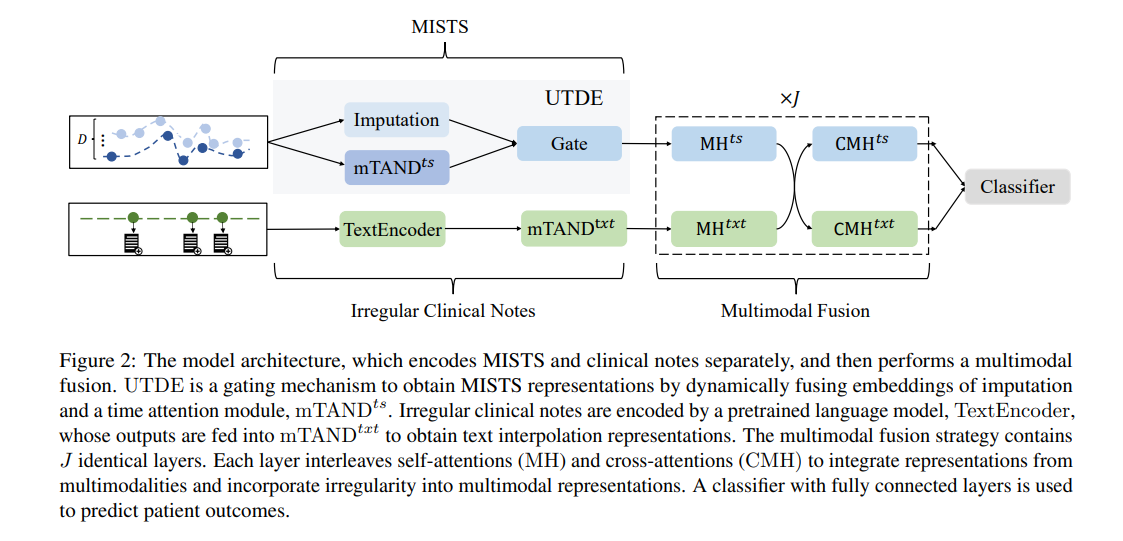

In [42]:
if 'Text' in args.modeltype:
    model = MULTCrossModel(args=args, device=device, orig_d_ts=17, orig_reg_d_ts=34, orig_d_txt=768,
                           ts_seq_num=args.tt_max, text_seq_num=args.num_of_notes, Biobert=BioBert)
else:
    model = TSMixed(args=args, device=device, orig_d_ts=17, orig_reg_d_ts=34, ts_seq_num=args.tt_max)

## train

This part of code train model. 
Given modeltype argument from above, it will set optimizer for different model type. (Text, Timeseries or mix)

In [43]:
if args.modeltype == 'TS':
        optimizer = torch.optim.Adam(model.parameters(), lr=args.ts_learning_rate)
elif args.modeltype == 'Text' or args.modeltype == 'TS_Text':
    optimizer = torch.optim.Adam([
        {'params': [p for n, p in model.named_parameters() if 'bert' not in n]},
        {'params': [p for n, p in model.named_parameters() if 'bert' in n], 'lr': args.txt_learning_rate}
    ], lr=args.ts_learning_rate)
else:
    raise ValueError("Unknown modeltype in optimizer.")

model, optimizer, train_dataloader, val_dataloader, test_data_loader = \
    accelerator.prepare(model, optimizer, train_dataloader, val_dataloader, test_data_loader)

trainer_irg(model=model, args=args, accelerator=accelerator, train_dataloader=train_dataloader, \
            dev_dataloader=val_dataloader, test_data_loader=test_data_loader, device=device, \
            optimizer=optimizer, writer=writer)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0 False



0it [00:00, ?it/s]
1it [00:00,  1.83it/s]
2it [00:00,  3.37it/s]
3it [00:00,  4.04it/s]
4it [00:00,  5.06it/s]
5it [00:01,  5.10it/s]
6it [00:01,  5.14it/s]
7it [00:01,  5.13it/s]
8it [00:01,  5.12it/s]
9it [00:01,  5.12it/s]
10it [00:02,  5.18it/s]
11it [00:02,  5.76it/s]
12it [00:02,  5.54it/s]
13it [00:02,  5.11it/s]
14it [00:02,  5.58it/s]
15it [00:03,  5.51it/s]
16it [00:03,  6.02it/s]
17it [00:03,  5.69it/s]
18it [00:03,  6.09it/s]
19it [00:03,  5.69it/s]
20it [00:03,  6.18it/s]
21it [00:04,  5.87it/s]
22it [00:04,  6.47it/s]
23it [00:04,  6.86it/s]
24it [00:04,  6.15it/s]
25it [00:04,  6.65it/s]
26it [00:04,  7.12it/s]
27it [00:04,  6.28it/s]
28it [00:05,  5.92it/s]
29it [00:05,  5.62it/s]
30it [00:05,  6.21it/s]
31it [00:05,  5.88it/s]
32it [00:05,  5.63it/s]
33it [00:05,  5.49it/s]
34it [00:06,  5.30it/s]
35it [00:06,  5.27it/s]
36it [00:06,  5.91it/s]
37it [00:06,  5.72it/s]
38it [00:06,  6.37it/s]
39it [00:06,  6.83it/s]
40it [00:07,  6.09it/s]
41it [00:07,  5.66it/s]
42it 

Current auc 0.8121432052353105
Best auc 0.8121432052353105
Current auprc 0.4312691590683202
Best auprc 0.4312691590683202
Current f1 0.33507853403141363
Best f1 0.33507853403141363


# Evaluate

In [44]:
eval_test(args, model, test_data_loader, device)

run/TS_Text/ihm/TS_Text/TS_48/Atten/Text_48/bioLongformer/1024/cross_attn3/irregular_TS_64/irregular_Text_64/5e-05_2_3_0.0004_1_8_128_1_2/f1/42.pth.tar


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.50it/s]


## Load evaluation result

the performance of 
proposed methods and baseline are measureds by the F,d AUP,o) and AUR.E,

In [48]:
for result_file in os.listdir(args.ck_file_path):
    if 'result.pkl' in result_file:
        eval_result_path = args.ck_file_path + result_file
        # print(eval_result_path)
        with open(eval_result_path,'rb') as f:
            evaluation_result = pickle.load(f)
            print(evaluation_result)

{42: {'auc': {'val': 0.8121432052353105, 'test': 0.7817799847211611}, 'auprc': {'val': 0.4312691590683202, 'test': 0.348923591347238}, 'f1': {'val': 0.33507853403141363, 'test': 0.25316455696202533}}}


# Conclusion

Sicne for the demonstration we only used 1000 sample for 1 epoch, and we fill in dummy data for entry with missing value, we could not achieve the same result as the paper describe.

We plan to further furnish the code and run on the full sample data with more epoch, to see if we could get the result as the paper describe.